# Tumor segmentation on MRI image stacks

In [1]:
# import libraries:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import os
import shutil

import nibabel
import pydicom

import faiutils

## Download instructions

### Data:

Segmentation: download segmentation_50cases.zip from synapse
https://www.synapse.org/#!Synapse:syn20771754
and unzip it; save to data directory under segmentation/.

### MRI images:
Edit syn.py to add your Synapse login info:
- Change syn.login() to syn.login(username,password)

Then from within data directory:
```
  import syn
  import synread
  ldf = syn.getSynData()
  syn.getXlsFiles(ldf)
  syn.checkPatientFiles()
  syn.getImsFor(synread.getSegPatients())
```

Had to download and rename files for 032 and 036 by hand.  They were missing initially and not properly added to the Synapse dataset, so the above doesn't get them.

In [2]:
# data location:
dataDirPath = Config.config_path/'data'/'nfmri2' # directory for sequence files
faiutils.modelDirPath = modelDirPath = dataDirPath/'models' # directory for model files

dataDirPath

Path('/home/isaac/.fastai/data/nfmri2')

## Parse patient XLS reports and segmentation masks

In [3]:
def getXlsPatients() :
    return set(int(fn[6:9]) for fn in os.listdir(dataDirPath/'xls'))
def getSegPatients() :
    return set(int(fn[13:16]) for fn in os.listdir(dataDirPath/'segmentation'))

allPatients = sorted(getXlsPatients())
assert allPatients==sorted(getSegPatients()),"patient list mismatch XLS, seg"

In [4]:
# read lists of tumor types (0=discrete, 1=plexiform) from patient reports:
def getPatientXls(patientNo) :
    return pd.read_excel(dataDirPath/'xls'/f'wbmri_{patientNo:03d}.xls')
def getPatientTumorTypes(patientNo) :
    "Returns dict: patientNo -> list of tumor types for patient's segmented tumors."
    df = getPatientXls(patientNo)
    assert df.iloc[3,2].lower()=='type', "missing tumor type header"
    pos = 4
    res = []
    while isinstance(df.iloc[pos,2],int) :
        res.append(df.iloc[pos,2])
        pos += 1
    return res
def getAllTumorTypes() :
    return dict((patientNo,getPatientTumorTypes(patientNo))
                for patientNo in allPatients)

In [5]:
# save dicts of tumor type lists and total number of tumors by patient:
allPatientTumorTypes = getAllTumorTypes()
allPatientTumorCount = dict((patientNo,len(tumorTypes)) for patientNo,tumorTypes in allPatientTumorTypes.items())
print(allPatientTumorTypes)
print(allPatientTumorCount)

{10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 19: [1, 0, 0, 0, 0, 0], 23: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 27: [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0], 32: [0, 1, 1, 1, 1, 0], 35: [0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 36: [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 45: [1, 0, 0, 0, 0, 0], 46: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 47: [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1], 48: [0, 0, 0, 0, 0], 52: [1, 0, 1, 1, 1, 0, 1, 1

In [6]:
# lowTumorPatients,highTumorPatients = set(),set()
# for patientNo,count in allPatientTumorCount.items() :
#     (lowTumorPatients if count<=12 else highTumorPatients).add(patientNo)
# len(lowTumorPatients),len(highTumorPatients)

In [7]:
# save consistent randomized value per patient for splitting cross-validation sets:
rng = random.Random(321)
patientRandVal = dict((patientNo,rng.random()) for patientNo in allPatients)

In [8]:
# get segmentation mask stack for a patient: 
def getPatientSeg(patientNo, dtype=np.uint8) :
    arr = nibabel.load(dataDirPath/'segmentation'/f'segmentation-{patientNo:03d}.nii.gz')
    arr = np.asanyarray(arr.dataobj, dtype=dtype)
    return arr.T

In [9]:
a = getPatientSeg(10)
a.min(), a.max(), a.shape, a.dtype

(0, 10, (20, 1086, 322), dtype('uint8'))

In [10]:
def getAllSegs(mergeTumorTypes=False) :
    """
    Returns dict: patientNo -> segmentation mask stack for all patients.
    If mergeTumorTypes is True, sets all tumor mask pixels to 1;
    if False, sets tumor pixels to 1 for discrete tumors and 2 for plexiform.
    """
    res = {}
    for patientNo in allPatients :
        tumorTypes = allPatientTumorTypes[patientNo]
        print(patientNo,end=' ')
        if not set(tumorTypes) <= {0,1} :
            print('unexpected tumor type',tumorTypes,end=' ')
        seg = getPatientSeg(patientNo)
#         tumorsMarked = set(seg.flatten())
#         tumorsInXls = set(range(len(tumorTypes)+1))
#         if tumorsMarked-tumorsInXls :
#             print('tumors in seg mask but not in XLS',tumorsMarked-tumorsInXls,end=' ')
#         if tumorsInXls-tumorsMarked :
#             print('tumors in XLS but not in seg mask',tumorsInXls-tumorsMarked,end=' ')
        mp = np.zeros(256,dtype=np.long)
        for i,tumorType in enumerate(tumorTypes) :
            mp[i+1] = 1 if mergeTumorTypes else tumorType+1
        seg = mp[seg]
#         print(set(seg.flatten()))
        res[patientNo] = tensor(seg).float()
    return res

In [11]:
mergeTumorTypes = True
codes = ['normal','tumor'] if mergeTumorTypes else ['normal','discrete','plexiform']
allPatientSegs = getAllSegs(mergeTumorTypes)
len(allPatientSegs), allPatientSegs[10].shape

10 19 23 27 32 35 36 45 46 47 48 52 53 61 63 65 69 72 76 77 81 85 87 88 89 90 95 97 98 99 102 106 107 109 114 119 120 123 127 136 138 144 158 196 222 224 225 227 268 279 

(50, torch.Size([20, 1086, 322]))

In [12]:
set(t.item() for t in allPatientSegs[99].flatten())

{0.0, 1.0}

## Read patient images

In [13]:
def getPatientImStack(patientNo, stackNo, scale=True) :
    """
    Returns image stack for a patient as a tensor, doing histogram-based scaling on the whole stack.
    """
    imDir = dataDirPath/f'imstacks-{patientNo:03d}'
    if not imDir.exists() : return None
    stacks = sorted(imDir.ls())
    if not 0<=stackNo<len(stacks) :
        return None
#     return torch.stack([dcmread(imFPath).scaled_px.hist_scaled()
#                           for imFPath in sorted(stacks[stackNo].ls())])
    imStack = torch.stack([dcmread(imFPath).scaled_px
                          for imFPath in sorted(stacks[stackNo].ls())])
    if scale :
        imStack = imStack.hist_scaled()
#         imStack = imStack/4.0 + 4.0*((imStack-0.8).clamp(0.0,0.2))
        imStack = imStack.clamp(0.0,0.75)/3.0 + 3.0*((imStack-0.75).clamp(0.0,0.25))
    return imStack
def getBothPatientImStacks(patientNo) :
    "Returns a list of both image stacks for a patient."
    return [getPatientImStack(patientNo,stackNo) for stackNo in [0,1]]

<AxesSubplot:>

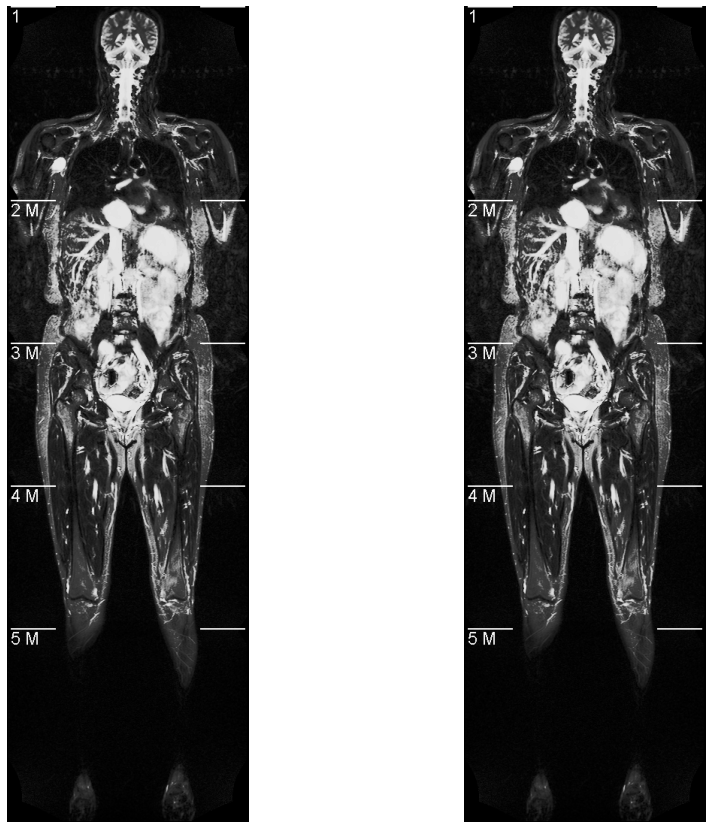

In [14]:
patientNo,imNo = 10,10
_,axes = plt.subplots(1,2,figsize=(15,15))
l = getPatientImStack(patientNo,0)
show_image(l[imNo],ax=axes[0],cmap='gray')
TensorImage(l[imNo]).show(ax=axes[1],cmap='gray')

## Find the STIR image stack for each patient
This is the image stack that the segmentation mask refers to.

In [15]:
def getAllStirIms() :
    "Returns dict: patientNo -> STIR image stack for all patients."
    res,possBoth = {},[]
    for patientNo in allPatients :
        seg = allPatientSegs[patientNo]
        imStacks = getBothPatientImStacks(patientNo)
        print(f'p{patientNo:03d} ss {tuple(seg.shape)},',end='')
        for stackNo,imStack in enumerate(imStacks) :
            if imStack is None : continue
            # imShapes = set()
            # for j,dcmIm in enumerate(imStack) :
            #     imShapes.add((dcmIm.Rows,dcmIm.Columns))
            # assert len(imShapes)==1,"multiple image shapes found!"
            print(f' s{stackNo}: ',tuple(imStack.shape),end='')
            # find the STIR image stack
            if imStack.shape == seg.shape :
                print(' ***',end='')
                if patientNo in res :
                    possBoth.append(patientNo)
                    if patientNo not in [65] :
                        continue
                res[patientNo] = imStack
        print()
    return res,possBoth

In [16]:
allPatientStirIms,possBoth = getAllStirIms()

p010 ss (20, 1086, 322), s0:  (20, 1086, 322) *** s1:  (20, 1089, 323)
p019 ss (20, 1092, 321), s0:  (20, 1091, 322) s1:  (20, 1092, 321) ***
p023 ss (20, 1105, 322), s0:  (20, 1102, 322) s1:  (20, 1105, 322) ***
p027 ss (20, 1094, 322), s0:  (20, 1094, 322) *** s1:  (20, 1086, 320)
p032 ss (20, 1104, 321), s0:  (20, 1104, 321) ***
p035 ss (20, 1098, 322), s0:  (20, 1087, 322) s1:  (20, 1098, 322) ***
p036 ss (20, 1089, 321), s0:  (20, 1062, 322) s1:  (20, 1089, 321) ***
p045 ss (20, 1074, 323), s0:  (20, 1074, 323) *** s1:  (20, 1069, 323)
p046 ss (20, 1096, 322), s0:  (20, 1092, 321) s1:  (20, 1096, 322) ***
p047 ss (20, 895, 322), s0:  (20, 889, 322) s1:  (20, 895, 322) ***
p048 ss (20, 1105, 321), s0:  (20, 1081, 322) s1:  (20, 1105, 321) ***
p052 ss (20, 1099, 322), s0:  (20, 1099, 322) ***
p053 ss (20, 1104, 322), s0:  (20, 1095, 320) s1:  (20, 1104, 322) ***
p061 ss (20, 1092, 323), s0:  (20, 1092, 323) *** s1:  (20, 1088, 323)
p063 ss (20, 1091, 321), s0:  (20, 1090, 322) s1:  

In [17]:
possBoth

[65, 69, 85, 109, 119, 222, 227]

In [18]:
assert allPatients==sorted(allPatientStirIms.keys()), "some patient STIR images not found"

In [19]:
print(sorted(v.shape[1] for v in allPatientStirIms.values()))

[895, 1058, 1059, 1059, 1059, 1060, 1060, 1061, 1061, 1074, 1086, 1088, 1089, 1090, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1093, 1093, 1094, 1096, 1098, 1099, 1104, 1104, 1105, 1105]


In [20]:
print(sorted(v.shape[2] for v in allPatientStirIms.values()))
print(sorted(v.shape[1] for v in allPatientStirIms.values()))

[320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323]
[895, 1058, 1059, 1059, 1059, 1060, 1060, 1061, 1061, 1074, 1086, 1088, 1089, 1090, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1092, 1093, 1093, 1094, 1096, 1098, 1099, 1104, 1104, 1105, 1105]


In [21]:
def saveToNpz(outFName) :
    "Save all patient STIR image stacks and segmentation mask stacks."
    save = dict((f'patient_{patientNo:03}_mri',allPatientStirIms[patientNo].numpy())
                for patientNo in allPatients)
    save.update((f'patient_{patientNo:03}_mask',allPatientSegs[patientNo].numpy())
                for patientNo in allPatients)
    np.savez_compressed(dataDirPath/outFName,**save)
    return save

In [22]:
# m = saveToNpz('nf_mri')
# len(m)

## Display image with segmentation mask

In [23]:
ipThresh = 0.75
def showMasked(im,seg,ax=None) :
    show_image(im*(((seg!=0)*2.0)+1.0)/3.0,ax=ax,cmap='gray')
def showPatientSeg(patientNo, imNo) :
    "Display image plus segmentation mask."
    imStack = allPatientStirIms[patientNo]
    segStack = allPatientSegs[patientNo]
    im,seg = imStack[imNo],segStack[imNo]
    _,axes = plt.subplots(1,3,figsize=(15,15))
    show_image(im,ax=axes[0],cmap='gray')
    showMasked(im,seg,ax=axes[1])
    im = im.clone()
    im[im>ipThresh] = 0.0
    show_image(im,ax=axes[2],cmap='gray')
    return im,seg

In [24]:
print(allPatients)

[10, 19, 23, 27, 32, 35, 36, 45, 46, 47, 48, 52, 53, 61, 63, 65, 69, 72, 76, 77, 81, 85, 87, 88, 89, 90, 95, 97, 98, 99, 102, 106, 107, 109, 114, 119, 120, 123, 127, 136, 138, 144, 158, 196, 222, 224, 225, 227, 268, 279]


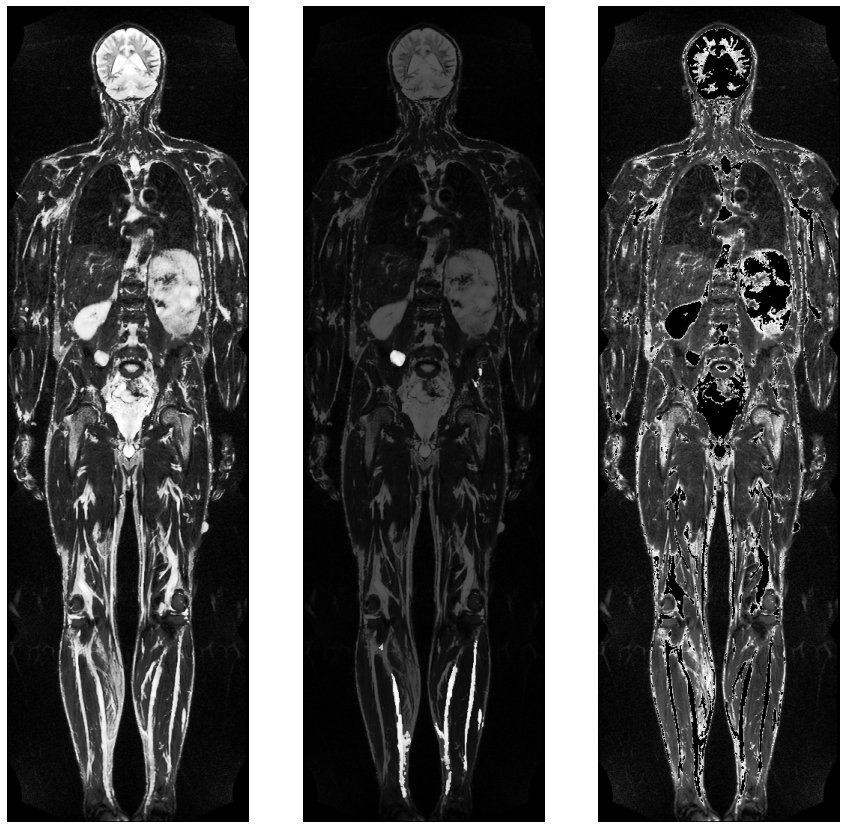

In [25]:
showPatientSeg(97, 10);

## Rotate image stack along different axes:

In [26]:
def rotateStackTopAxis(stack, angle, cls) :
    stack = stack.data.clone()
    stack = stack.permute(1,0,2) # S,H,W -> H,S,W
    stack = stack[None].expand(1,*stack.shape) # -> 2,H,S,W
    stack = cls(stack).rotate(draw=angle, p=1., pad_mode='zeros')
    return stack[0].permute(1,0,2) # -> S,H,W
def rotateImStackTopAxis(imStack,angle) :
    return rotateStackTopAxis(imStack,angle,TensorImage)
# def rotateMaskStackTopAxis(maskStack,angle) :
#     return rotateStackTopAxis(maskStack,angle,TensorMask)
def rotateStackSideAxis(stack, angle, cls) :
    stack = stack.data.clone()
    stack = stack.permute(2,0,1) # S,H,W -> W,S,S
    stack = stack[None].expand(1,*stack.shape) # -> 2,W,S,H
    stack = cls(stack).rotate(draw=angle, p=1., pad_mode='zeros')
    return stack[0].permute(1,2,0) # -> S,H,W
def rotateImStackSideAxis(imStack,angle) :
    return rotateStackSideAxis(imStack,angle,TensorImage)
def rotateMaskStackSideAxis(maskStack,angle) :
    return rotateStackSideAxis(maskStack,angle,TensorMask)
def randomRotateImAndMaskStack(imStack, maskStack, pRand3DRot=0.5, max3DRotAngle=0.1) :
    if random.random() >= pRand3DRot :
        return imStack, maskStack
    topAngle = random.uniform(-max3DRotAngle,max3DRotAngle)
    imStack = rotateImStackTopAxis(imStack,topAngle)
    maskStack = rotateImStackTopAxis(maskStack,topAngle)
    sideAngle = random.uniform(-max3DRotAngle,max3DRotAngle)
    imStack = rotateImStackTopAxis(imStack,sideAngle)
    maskStack = rotateImStackTopAxis(maskStack,sideAngle)
    return imStack,maskStack
def showImStack(imStack) :
    _,axes = plt.subplots(2,10,figsize=(15,15))
    for i in range(2) :
        for j in range(10) :
            show_image(imStack[i*10+j],ax=axes[i][j])

In [27]:
i,im = allPatientStirIms[35],allPatientSegs[35]
i.shape,im.shape

(torch.Size([20, 1098, 322]), torch.Size([20, 1098, 322]))

In [28]:
ir,imr = randomRotateImAndMaskStack(i,im,pRand3DRot=1.0)

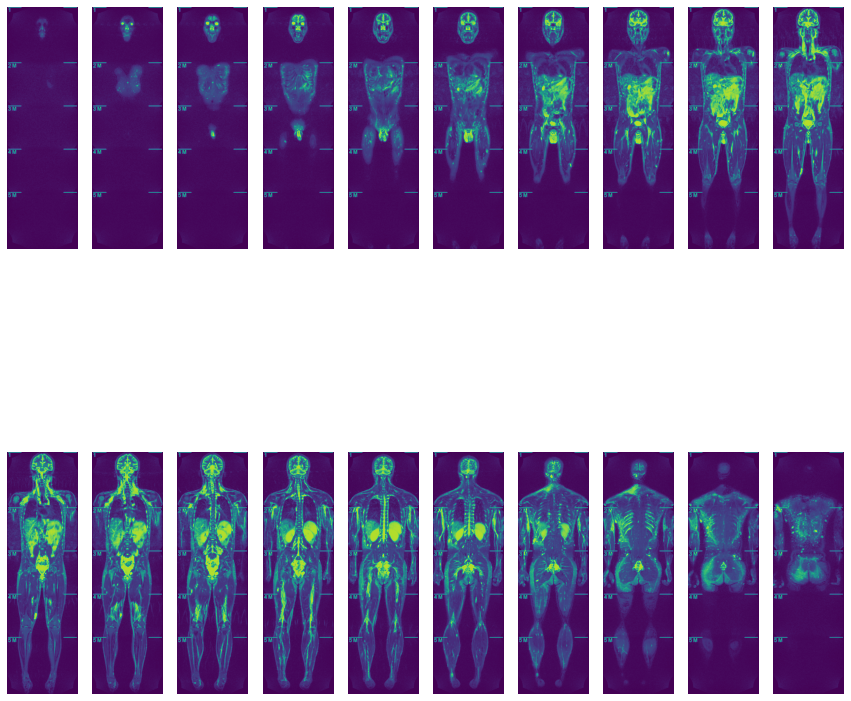

In [29]:
showImStack(ir)

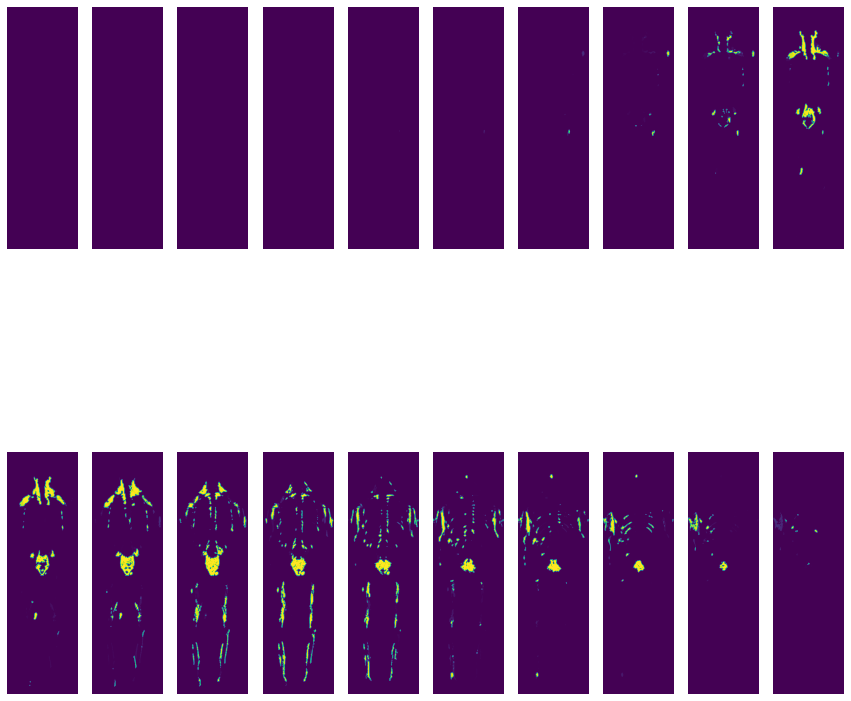

In [30]:
showImStack(imr)

In [31]:
i = allPatientStirIms[35]
i.shape

torch.Size([20, 1098, 322])

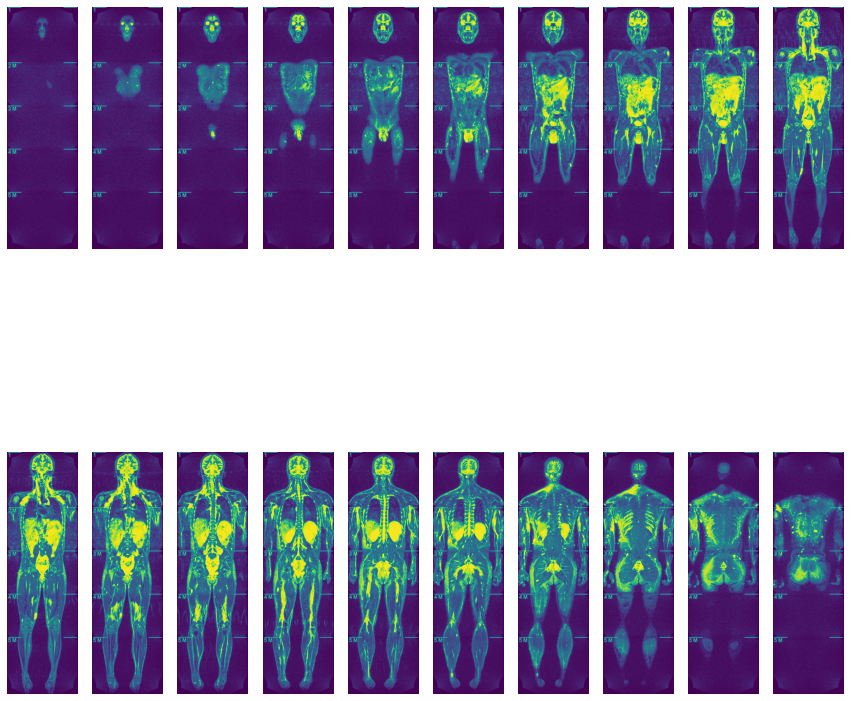

In [32]:
showImStack((1.0-((1.0-i)**2)))

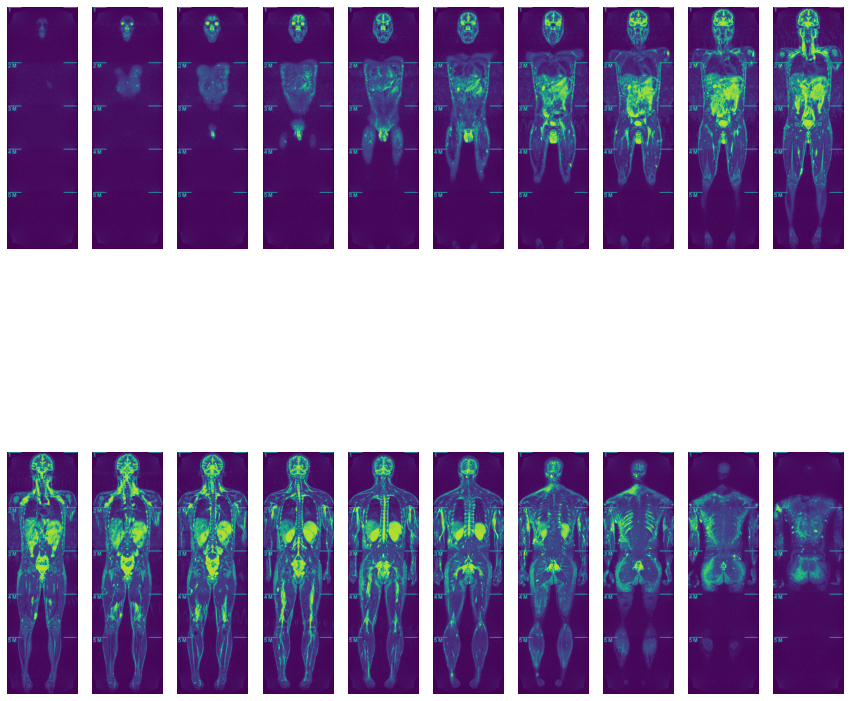

In [33]:
showImStack(i)

In [34]:
ir = rotateImStackTopAxis(i,0.2)

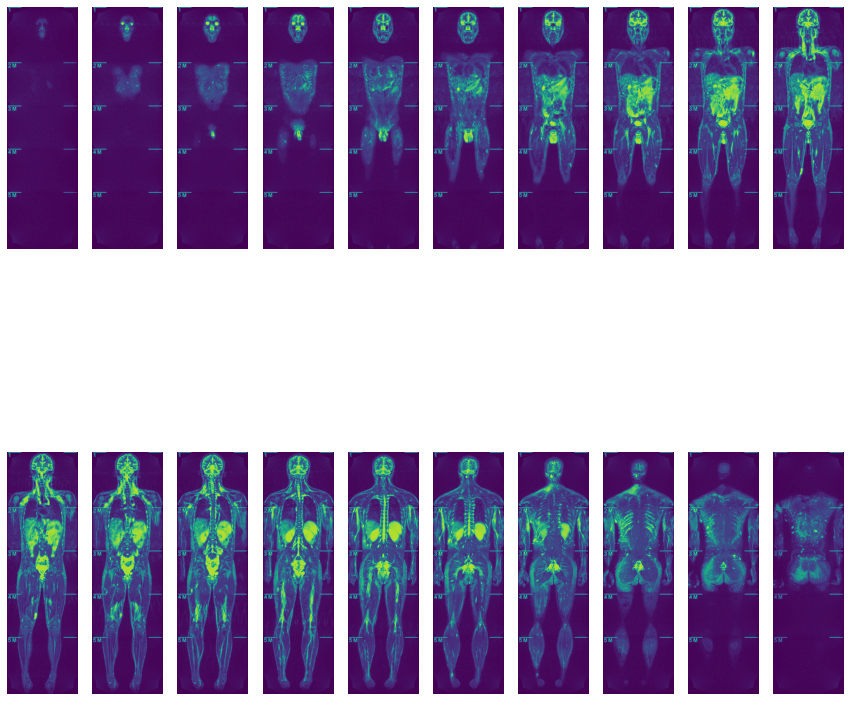

In [35]:
showImStack(ir)

In [36]:
ir = rotateImStackSideAxis(i,0.2)

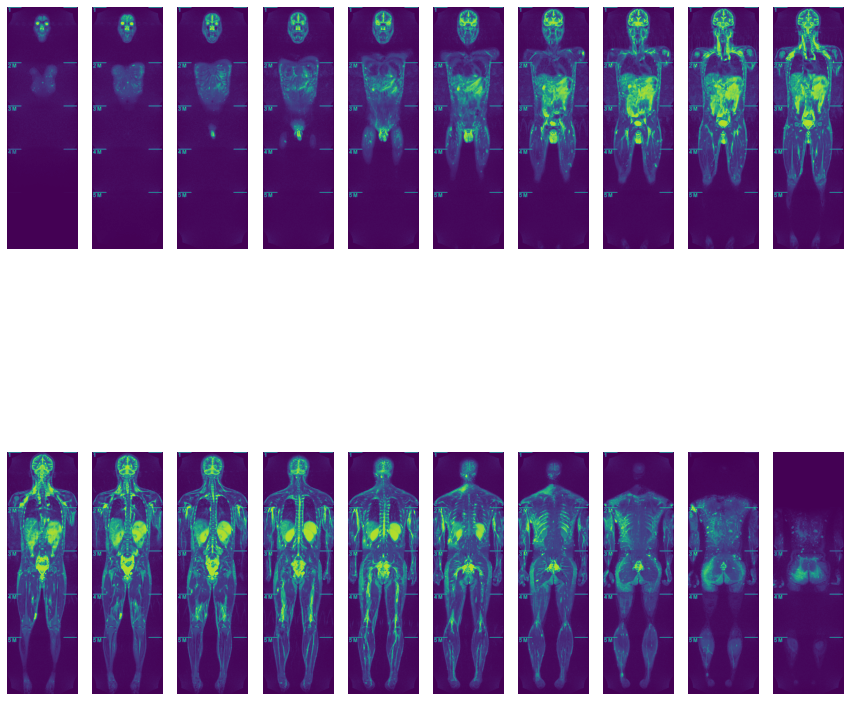

In [37]:
showImStack(ir)

## Create datablocks from in-memory image and segmentation stacks

In [38]:
nTiles = 1
tileHeight,tileWidth = 1100,320
def tileRStartEnd(tileNo, nRows) :
    return 0,min(tileHeight,nRows)
# nTiles = 2
# tileHeight,tileWidth,tileStride = 580,320,550
# def tileRStartEnd(tileNo, nRows) :
#     rEnd = min(nRows, tileNo*tileStride+tileHeight)
#     return rEnd-tileHeight,rEnd

def isValidationPatientNo(patientNo, vSplit=0.2, vStartSplit=0.0) :
    return vStartSplit <= patientRandVal[patientNo] < vStartSplit+vSplit
def isValidationItem(patientItem, vSplit=0.2, vStartSplit=0.0) :
    return isValidationPatientNo(int(patientItem[1:].split('_')[0]), vSplit, vStartSplit)
def validationPatients(vSplit=0.2, vStartSplit=0.0) :
    return [pNo for pNo in allPatients if isValidationPatientNo(pNo,vSplit,vStartSplit)]

def getStats(im) :
    return im.mean(),im.std(),im.min(),im.max()
def getPctPos(mask) :
    return (mask==1).sum().item()/mask.numel()
def getPatientPctPos(pNo) :
    return getPctPos(allPatientSegs[pNo][1:19])
def getAvgPatientPctPos(pNos) :
    l = [getPatientPctPos(pNo) for pNo in pNos]
    return sum(l)/len(l)
def printPatientPctPos(pNos) :
    l = [getPatientPctPos(pNo) for pNo in pNos]
    for pNo,v in zip(pNos,l) :
        print(pNo,v)
    print('mean',sum(l)/len(l))

def is3Chan(x) :
    return (x.shape[0]==3 or x.shape[1]==3)
def mynorm(x) :
    if is3Chan(x) :
        return (x-0.2) / 0.25
    return TensorMask((x>=0.5).long())
def mydenorm(x) :
    if is3Chan(x) :
        return (x*0.25 + 0.2)
    return x
class MyNormalize(DisplayedTransform):
    "My normalize/denorm batch of `TensorImage`"
    def setups(self, dl:DataLoader): pass
    def encodes(self, x:TensorImage):
        # print('encshape',x.shape)
        return mynorm(x)
    def decodes(self, x:TensorImage):
        # print('decshape',x.shape)
        return mydenorm(x)
    _docs=dict(encodes="My normalize batch", decodes="My denormalize batch")
def myipnorm(x) :
    """
    For inpainting
    set all bright x pixels to 1.0 so we train to fill in normal bright areas
    set all non-bright y pixels to 0.0 so they won't be counted in the loss
    """
    x = x.clone()
    if is3Chan(x) :
        x[x>=ipThresh] = 1.0
        return mynorm(x)
    x[x<ipThresh] = 0.0
    return x
class MyIPNormalize(DisplayedTransform):
    "My normalize/denorm batch of `TensorImage`"
    def setups(self, dl:DataLoader): pass
    def encodes(self, x:TensorImage):
        # print('encshape',x.shape)
        return myipnorm(x)
#         x = x.clone()
#         if is3Chan(x) :
#             x[x>=ipThresh] = 1.0
#             return mynorm(x)
#         else : # target
#             x[x<ipThresh] = 0.0
#             return x
    def decodes(self, x:TensorImage):
        # print('decshape',x.shape)
        return mydenorm(x)
#         if is3Chan(x) :
#             return mydenorm(x)
#         else : # target
#             return x
    _docs=dict(encodes="My IP normalize batch", decodes="My IP denormalize batch")

augAllPatientStirIms, augAllPatientSegs = allPatientStirIms,allPatientSegs
def randomRotateAug(vSplit=0.2, vStartSplit=0.0, pRand3DRot=0.5, max3DRotAngle=0.1) :
    "Augment by randomly rotating the training images along the top and side axes."
    augAllPatientStirIms = dict(allPatientStirIms)
    augAllPatientSegs = dict(allPatientSegs)
    if pRand3DRot == 0.0 :
        return
    print('random rotate p',pRand3DRot,'maxA',max3DRotAngle)
    for patientNo,imStack in allPatientStirIms.items() :
        if not isValidationPatientNo(patientNo, vSplit, vStartSplit) :
            maskStack = allPatientSegs[patientNo]
            augAllPatientStirIms[patientNo], augAllPatientSegs[patientNo] = randomRotateImAndMaskStack(
                                        imStack, maskStack, pRand3DRot=pRand3DRot, max3DRotAngle=max3DRotAngle)

class rrAugCB(Callback) :
    def __init__(self, vSplit=0.2, vStartSplit=0.0, pRand3DRot=0.5, max3DRotAngle=0.1, **kwargs) :
        super().__init__()
        self.rrAug = partial(randomRotateAug, vSplit=vSplit, vStartSplit=vStartSplit,
                                                 pRand3DRot=pRand3DRot, max3DRotAngle=max3DRotAngle)
    def before_epoch(self) :
        self.rrAug()

# class myTensorImage(TensorImage) :
#     def show(self,**kwargs) :
#         print('showim min',self.min(),'max',self.max(),kwargs)
#         TensorImage(self*0.0).show(**kwargs)
# class myTensorMask(TensorMask) :
#     def show(self,**kwargs) :
#         kwargs = dict(kwargs, cmap='brg')
#         print('show min',self.min(),'max',self.max(),kwargs)
#         super().show(**kwargs)

def openPatientGrayIm(patientItem) :
    patientNo,imNo,tileNo = [int(s) for s in patientItem[1:].split('_')[:3]]
    imStack = augAllPatientStirIms[patientNo]
    rStart,rEnd = tileRStartEnd(tileNo, imStack.shape[1])
#
    res = torch.zeros(3,tileHeight,tileWidth)
    for i in range(3) :
        res[i,:rEnd,:tileWidth] = imStack[imNo][:rEnd,:tileWidth]
    return TensorImage(res)
#     res = TensorImage(torch.stack([imStack[imNo][rStart:rEnd,0:tileWidth]
#                                    for _ in range(3)]))
#     return res
def openPatientIm(patientItem) :
    patientNo,imNo,tileNo = [int(s) for s in patientItem[1:].split('_')[:3]]
    imStack = augAllPatientStirIms[patientNo]
    rStart,rEnd = tileRStartEnd(tileNo, imStack.shape[1])
#
    res = torch.zeros(3,tileHeight,tileWidth)
    for i in range(3) :
        res[i,:rEnd,:tileWidth] = imStack[imNo+i-1][:rEnd,:tileWidth]
    return TensorImage(res)
#     res = TensorImage(imStack[imNo-1:imNo+2,rStart:rEnd,0:tileWidth])
#     return res
def openPatientMask(patientItem) :
    patientNo,imNo,tileNo = [int(s) for s in patientItem[1:].split('_')[:3]]
    segStack = augAllPatientSegs[patientNo]
    rStart,rEnd = tileRStartEnd(tileNo, segStack.shape[1])
#
    res = torch.zeros(1,tileHeight,tileWidth)
    res[0,:rEnd,:tileWidth] = segStack[imNo][:rEnd,:tileWidth]
    return TensorImage(res)
#     return TensorImage(segStack[imNo][rStart:rEnd,0:tileWidth][None])
# def openPatientIPIm(patientItem) :
#     res = openPatientIm(patientItem).clone()
#     res[res>ipThresh] = 1.0
# #     return torch.stack([res[1] for _ in range(3)])
#     return res
def openPatientIPTarget(patientItem) :
    patientNo,imNo,tileNo = [int(s) for s in patientItem[1:].split('_')[:3]]
    imStack = augAllPatientStirIms[patientNo]
    rStart,rEnd = tileRStartEnd(tileNo, imStack.shape[1])
    res = TensorImage(imStack[imNo:imNo+1,rStart:rEnd,0:tileWidth]).clone()
    mask = openPatientMask(patientItem)[None]
    res[mask>0] = 0.0
    return res

def patientItems(*args, vSplit=0.2, vStartSplit=0.0, forIP=False) :
    res = []
    for patientNo in allPatients :
        for i in range(1,19) :
            patientItems = [f'p{patientNo:03}_{i:02}_{j:02}' for j in range(nTiles)]
            for patientItem in patientItems :
                if forIP :
                    im = openPatientIm(patientItem)
                    if im[im>ipThresh].sum() > 1000 :
                        res.append(patientItem)
                    continue
                res.append(patientItem)
                if isValidationItem(patientItem,vSplit,vStartSplit) :
                    continue
                mask = openPatientMask(patientItem)
                if getPctPos(mask) > 0.001 :
                    res.append(patientItem)
                    if getPctPos(mask) > 0.01 :
                        res.append(patientItem)
    return res
def getDataBlock(openItemF=openPatientIm, vSplit=0.2, vStartSplit=0.0, **kwargs) :
    return DataBlock(blocks=(TransformBlock(type_tfms=openItemF),
                             TransformBlock(type_tfms=openPatientMask,
                                            item_tfms=AddMaskCodes(codes=codes),
                                           )),
                     get_items=partial(patientItems,vSplit=vSplit,vStartSplit=vStartSplit,forIP=False),
                     splitter=FuncSplitter(partial(isValidationItem,vSplit=vSplit,vStartSplit=vStartSplit)),
                     batch_tfms=aug_transforms(
                         do_flip=False, max_rotate=2.5, max_zoom=1.05, max_warp=0.05, max_lighting=0.0,
#                          do_flip=False, max_rotate=5.0, max_zoom=1.1, max_warp=0.1, max_lighting=0.1,
                         size=(tileHeight,tileWidth),
                     ),
                    )
def getIPDataBlock(openItemF, vSplit=0.2, vStartSplit=0.0) :
    return DataBlock(blocks=(TransformBlock(type_tfms=openItemF),
                             TransformBlock(type_tfms=openPatientIPTarget)),
                     get_items=partial(patientItems,vSplit=vSplit,vStartSplit=vStartSplit,forIP=True),
                     splitter=FuncSplitter(partial(isValidationItem,vSplit=vSplit,vStartSplit=vStartSplit)),
                     batch_tfms=aug_transforms(
                         do_flip=False, max_rotate=2.5, max_zoom=1.05, max_warp=0.05, max_lighting=0.0,
                         size=(tileHeight,tileWidth),
                     ),
                    )

In [39]:
printPatientPctPos(allPatients)

10 0.0023698632574443287
19 0.0004003438582877835
23 0.0007596126521957724
27 0.01610263902609503
32 0.00224489693540215
35 0.016527477652447956
36 0.02243763033907469
45 0.000497418739458278
46 0.017701139220101456
47 0.01112499084323228
48 0.00154196993119478
52 0.018072926576704715
53 0.0077949185345215595
61 0.002133601978803217
63 0.0024599455756672407
65 0.0002826705159044337
69 0.009443999287749288
72 0.0147603296688699
76 0.002155180560753316
77 0.00014945434973642118
81 0.0007668299323342563
85 0.0017025028634935755
87 0.001859513899398426
88 0.0024190062889753294
89 0.0007325131463337337
90 0.0006246182844469417
95 0.001791721028481153
97 0.0013471650468554494
98 0.0004008385219565344
99 0.026317411022379965
102 0.004198139679506139
106 0.0016332892433797068
107 0.05828398534745637
109 0.012000999230101398
114 0.014132967373892783
119 0.0023698288873817332
120 0.0036888550453131382
123 0.0003991114877934559
127 0.010880151019902572
136 0.0029028541603014564
138 0.007960365491

In [40]:
defVSplit=0.2
defVStartSplit=0.0
printPatientPctPos(validationPatients(defVSplit,defVStartSplit))

19 0.0004003438582877835
72 0.0147603296688699
107 0.05828398534745637
127 0.010880151019902572
227 0.007075656331482115
268 0.00042677448337825695
mean 0.015304540118229501


<AxesSubplot:>

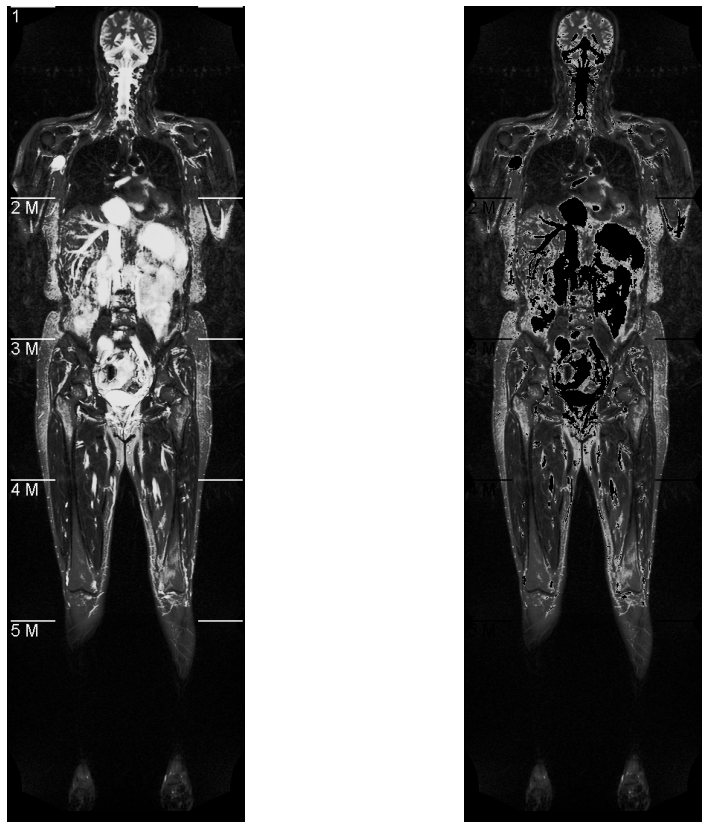

In [41]:
_,axes = plt.subplots(1,2,figsize=(15,15))
pItem = 'p010_010_0'
im = openPatientGrayIm(pItem).data.clone()
show_image(im,ax=axes[0],cmap='gray')
im[im>=ipThresh] = 0.0
show_image(im,ax=axes[1],cmap='gray')
# show_image(openPatientIPIm(pItem)[1],ax=axes[0][1],cmap='gray')
# show_image(openPatientIPIm(pItem)[1]==1.0,ax=axes[1][0],cmap='gray')
# im = openPatientIPTarget(pItem).clone()
# im[im<ipThresh] = 0.0
# show_image(im,ax=axes[2],cmap='gray')

In [42]:
db = getDataBlock(openPatientIm)

In [43]:
db.summary('xxx',bs=2)

Setting-up type transforms pipelines
Found 1411 items
2 datasets of sizes 1303,108
Setting up Pipeline: openPatientIm
Setting up Pipeline: openPatientMask

Building one sample
  Pipeline: openPatientIm
    starting from
      p010_01_00
    applying openPatientIm gives
      TensorImage of size 3x1100x320
  Pipeline: openPatientMask
    starting from
      p010_01_00
    applying openPatientMask gives
      TensorImage of size 1x1100x320

Final sample: (TensorImage([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0.,

## Create dataloaders and learners for segmentation

In [44]:
def showBatch(dls) :
    b = first(dls.train)
    _,axes = plt.subplots(2,2,figsize=(15,15))
    for i,(x,y) in enumerate(zip(*b)) :
        if i>=4 :
            break
        showMasked(mydenorm(x),y,ax=axes[i//2][i%2])

classWeights = tensor([1.0,10.0]).cuda()
crossEntLoss = CrossEntropyLossFlat(axis=1, weight=classWeights)

def focalTverskyLoss(output, targ, smooth=1.0, alpha=0.7, gamma=0.75) :
    "output is bs,c,h,w; targ is bs,h,w"
    pred = output.softmax(axis=1)[:,1,:,:].flatten()
    targ = targ.flatten()
    truePos = (targ*pred).sum()
    falseNeg = (targ*(1-pred)).sum()
    falsePos = ((1-targ)*pred).sum()
    tverskyCoeff = ((truePos + smooth)
                    / (truePos + alpha*falseNeg + (1-alpha)*falsePos + smooth))
    return torch.pow((1.0 - tverskyCoeff), gamma)
def combLossFunc(output, targ) :
    return crossEntLoss(output,targ) + focalTverskyLoss(output,targ,gamma=1.25)


def diceLossFunc(output, targ, eps=1e-7) :
    "output is bs,c,h,w; targ is bs,h,w"
    targOneHot = torch.eye(output.shape[1])[targ].permute(0,3,1,2).clone().cuda()
    # print(targOneHot.shape)
    pred = F.softmax(output,dim=1)
    # print(pred.shape)
    inter = (pred*targOneHot).sum(axis=[-1,-2])
    union = (pred+targOneHot).sum(axis=[-1,-2])
    return 1.- (2. * inter/(union+eps)).mean()

class testCB(Callback) :
    def before_epoch(self) : print('epoch begin')

#partial(focalTverskyLoss,gamma=1.25),
#crossEntLoss,
#CrossEntropyLossFlat(axis=1, weight=tensor([1.0,5.0]).cuda()),
#combLossFunc,

# o0 = learn.model(b0)

# diceLossFunc(o0,b1)

# m = openPatientMask('p035_10_1')
# mm = torch.stack([m,m,m])

# torch.eye(2)[mm].shape,torch.eye(2)[mm].permute(0,3,1,2)

def setupSegTraining(lossFunc=crossEntLoss, bs=4, seed=None, **kwargs) :
    global db, dls, learn
    if seed is not None :
        faiutils.randomSeedForTraining(seed)
    db = getDataBlock(**kwargs)
    dls = db.dataloaders(source='xxx', bs=bs, num_workers=0)
    dls.after_batch.add(MyNormalize())
    learn = unet_learner(dls, resnet34,
                     loss_func=lossFunc,
                     metrics=[Recall(axis=1),Precision(axis=1),F1Score(axis=1)],
                     model_dir=modelDirPath, normalize=False,
                       cbs=[rrAugCB(**kwargs),
                            SaveModelCallback(fname='segModel',monitor='f1_score',)],
                    )

def trySegTraining(lr=0.001, nEp1=20, nEp2=0, wd=0.1, **kwargs) :
    setupSegTraining(**kwargs)
    if nEp2 == 0 :
        learn.fit_one_cycle(nEp1,lr,wd=wd)
    else :
        learn.fine_tune(nEp2,lr,nEp1,wd=wd)

def tryCrossVal(nSplits=10, **kwargs) :
    for i in range(nSplits) :
        vSplit=1.0/nSplits
        vStartSplit=i*vSplit
        trySegTraining(**dict(kwargs, vSplit=vSplit,vStartSplit=vStartSplit))

defSegHP = dict(
    lr=0.001, nEp1=20, nEp2=0, wd=0.1,
    openItemF=openPatientIm,
    vSplit=defVSplit, vStartSplit=defVStartSplit,
    lossFunc=crossEntLoss,
    bs=4, seed=None,
    pRand3DRot=0.0, max3DRotAngle=0.1,
)

In [45]:
setupSegTraining(**dict(defSegHP, bs=2, seed=3141))

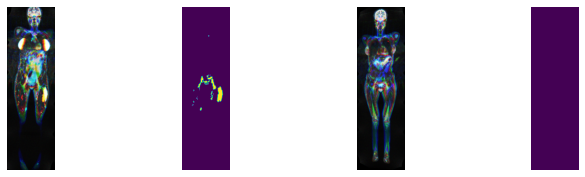

In [46]:
dls.show_batch()

In [47]:
dls.train.after_batch

Pipeline: Warp -- {'magnitude': 0.05, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': (1100, 320), 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'} -> MyNormalize -- {}

In [48]:
b0,b1 = dls.one_batch()

In [49]:
getStats(b0)

(TensorImage(-0.3062, device='cuda:0'),
 TensorImage(0.7177, device='cuda:0'),
 TensorImage(-0.8000, device='cuda:0'),
 TensorImage(3.2000, device='cuda:0'))

In [51]:
trySegTraining(**dict(defSegHP, bs=2, seed=3141, pRand3DRot=0.5))

random rotate p 0.5 maxA 0.1
Better model found at epoch 0 with f1_score value: 0.44076691247939925.
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
Better model found at epoch 3 with f1_score value: 0.5221634505267979.
random rotate p 0.5 maxA 0.1
Better model found at epoch 4 with f1_score value: 0.542308753162963.
random rotate p 0.5 maxA 0.1
Better model found at epoch 5 with f1_score value: 0.5576586572710486.
random rotate p 0.5 maxA 0.1
Better model found at epoch 6 with f1_score value: 0.6243491580182059.
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
random rotate p 0.5 maxA 0.1
